<a href="https://colab.research.google.com/github/GeNiaaz/NUStress/blob/master/Black_Gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [35]:
'''
install dependencies
'''

!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-988qs0u8
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-988qs0u8
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266983 sha256=51429d261cadf28d92897df8eebafd42a7e7ac3f4985d32d882249c4e9e4f072
  Stored in directory: /tmp/pip-ephem-wheel-cache-rle3qssx/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


In [82]:
'''
importing libraries
'''

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# common libraries
import numpy as np
import cv2
import random
import os
import pandas as pd
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from google.colab import drive

In [37]:
'''
setup of datasets
'''

# mounting google drive to be accessed by Colab

# to delete
# from google.colab import drive
drive.mount('/content/drive')

# Training dataset registering
register_coco_instances("train_dataset_2", {}, "/content/drive/My Drive/oil_tank/train/train_coco_4.json", "/content/drive/My Drive/oil_tank/train")

# Validation dataset registering
register_coco_instances("valid_dataset_2", {}, "/content/drive/My Drive/oil_tank/valid/valid_coco_4.json", "/content/drive/My Drive/oil_tank/valid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# to delete
# cfg.OUTPUT_DIR = "content/drive/My Drive/oil_tank/model"

'''
configuring model for transfer learning
'''
def configure():
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
    cfg.DATASETS.TRAIN = ("train_dataset_1",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  
    cfg.SOLVER.MAX_ITER = 10000    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)

[06/28 06:53:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!


# Execution

In [43]:
# configures model
configure()

# initiate training
trainer.train()

[06/28 06:53:16 d2.engine.train_loop]: Starting training from iteration 0
[06/28 06:53:25 d2.utils.events]:  eta: 1:10:40  iter: 19  total_loss: 1.244  loss_cls: 0.715  loss_box_reg: 0.487  loss_rpn_cls: 0.029  loss_rpn_loc: 0.013  time: 0.4192  data_time: 0.0256  lr: 0.000005  max_mem: 3055M
[06/28 06:53:33 d2.utils.events]:  eta: 1:06:56  iter: 39  total_loss: 1.290  loss_cls: 0.682  loss_box_reg: 0.547  loss_rpn_cls: 0.024  loss_rpn_loc: 0.012  time: 0.4077  data_time: 0.0043  lr: 0.000010  max_mem: 3055M
[06/28 06:53:41 d2.utils.events]:  eta: 1:07:47  iter: 59  total_loss: 1.101  loss_cls: 0.594  loss_box_reg: 0.456  loss_rpn_cls: 0.025  loss_rpn_loc: 0.008  time: 0.4092  data_time: 0.0050  lr: 0.000015  max_mem: 3055M
[06/28 06:53:50 d2.utils.events]:  eta: 1:08:19  iter: 79  total_loss: 1.026  loss_cls: 0.516  loss_box_reg: 0.483  loss_rpn_cls: 0.028  loss_rpn_loc: 0.011  time: 0.4110  data_time: 0.0045  lr: 0.000020  max_mem: 3055M
[06/28 06:53:58 d2.utils.events]:  eta: 1:06:5

In [84]:
'''
Evaluator to check accuracy of detection against validation dataset
'''

# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("valid_dataset_1", )
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("valid_dataset_1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "valid_dataset_1")
inference_on_dataset(trainer.model, val_loader, evaluator)

[06/28 09:08:48 d2.data.datasets.coco]: Loaded 131 images in COCO format from /content/drive/My Drive/oil_tank/valid/valid_coco_4.json
[06/28 09:08:48 d2.data.common]: Serializing 131 elements to byte tensors and concatenating them all ...
[06/28 09:08:48 d2.data.common]: Serialized dataset takes 0.02 MiB
[06/28 09:08:48 d2.evaluation.evaluator]: Start inference on 131 images
[06/28 09:08:49 d2.evaluation.evaluator]: Inference done 11/131. 0.0993 s / img. ETA=0:00:12
[06/28 09:08:54 d2.evaluation.evaluator]: Inference done 61/131. 0.0992 s / img. ETA=0:00:07
[06/28 09:08:59 d2.evaluation.evaluator]: Inference done 111/131. 0.0993 s / img. ETA=0:00:02
[06/28 09:09:02 d2.evaluation.evaluator]: Total inference time: 0:00:12.723842 (0.100983 s / img per device, on 1 devices)
[06/28 09:09:02 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.099305 s / img per device, on 1 devices)
[06/28 09:09:02 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06

OrderedDict([('bbox',
              {'AP': 86.54729546446124,
               'AP50': 99.0704303006358,
               'AP75': 99.0704303006358,
               'APl': 96.6031987814166,
               'APm': 88.52204702356244,
               'APs': 57.57547877040452})])

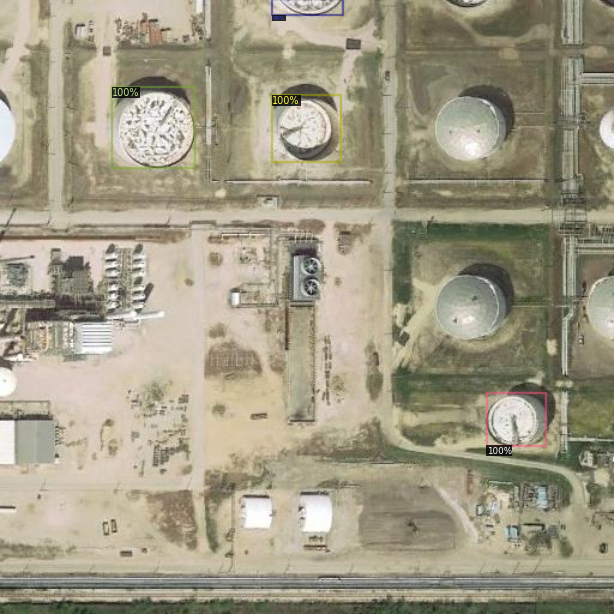

In [86]:
'''
manually checking output
'''

# to delete
# from detectron2.utils.visualizer import ColorMode

test_image = "/content/drive/My Drive/oil_tank/valid/01_6_3.jpg"
im = cv2.imread(test_image)
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Work in progress


To fix: Not able to save / load model 

In [ ]:
# Saving ML model
model_save_name = "9k_model.pt"
# model = "/content/output/model_final.pth"
path_to_model = "/content/drive/My Drive/oil_tank/model/9k_model.pt"
torch.save(model.state_dict(), path_to_model)

In [ ]:
# Loading ML model
saved_model = "model_to_use.pth"
model_path = "/content/drive/My drive/oil_tank/model/model_final.pth"
model_instance.load_state_dict(torch.load(model_path))

To fix: Add log earlier in the file to log data to be viewed 

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output